In [1]:
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer
import numpy as np
from sklearn.metrics.cluster import silhouette_score #evaluates how good clustering is
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy.stats as stats

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.preprocessing import StandardScaler


#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.tree import export_graphviz

In [2]:
#Load Data
restdata = pd.read_csv('Restaurant_Inspections.csv')

In [3]:
restdatacleaned = restdata.copy()
#Replace spaces with _ in column names
restdatacleaned.columns = restdata.columns.map(lambda x: x.replace(" ","_"))

In [4]:
restdatacleaned.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,VIOLATION_CODE,VIOLATION_DESCRIPTION,CRITICAL_FLAG,SCORE,GRADE,GRADE_DATE,RECORD_DATE,INSPECTION_TYPE
0,40393378,E.J LUNCHEONETTE,MANHATTAN,1271,THIRD AVENUE,10021,2124720600,American,07/12/2016,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,31.0,NaN,NaN,04/22/2017,Cycle Inspection / Initial Inspection
1,41030615,SERAFINA,MANHATTAN,210,WEST 55 STREET,10019,2123151700,Italian,03/18/2016,Violations were cited in the following area(s).,09C,Food contact surface not properly maintained.,Not Critical,4.0,A,03/18/2016,04/22/2017,Cycle Inspection / Initial Inspection
2,40871795,WONDEE SIAM II,MANHATTAN,813,9 AVENUE,10019,9172861726,Thai,12/23/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,29.0,NaN,NaN,04/22/2017,Cycle Inspection / Initial Inspection
3,40750612,STROKOS PIZZA DELI,MANHATTAN,888,10 AVENUE,10019,2125816262,American,09/20/2016,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,13.0,A,09/20/2016,04/22/2017,Cycle Inspection / Initial Inspection
4,50036944,AMBER,MANHATTAN,103,W 70TH ST,10023,2127998100,Asian,11/12/2015,Violations were cited in the following area(s).,09B,Thawing procedures improper.,Not Critical,9.0,A,11/12/2015,04/22/2017,Pre-permit (Operational) / Re-inspection


In [4]:
#clean up column names by lowercasing them
restdatacleaned.columns = restdatacleaned.columns.str.lower()

In [5]:
#Investigate Data types
restdatacleaned.dtypes

camis                      int64
dba                       object
boro                      object
building                  object
street                    object
zipcode                    int64
phone                     object
cuisine_description       object
inspection_date           object
action                    object
violation_code            object
violation_description     object
critical_flag             object
score                    float64
grade                     object
grade_date                object
record_date               object
inspection_type           object
dtype: object

In [6]:
#Drop columns that don't add to analysis
restdatacleaned = restdatacleaned.drop(['camis','dba','inspection_date','building','street','phone','zipcode','action','violation_description','grade_date','record_date','inspection_type','grade'], axis=1)

In [7]:
#Drop all na values
restdatacleaned = restdatacleaned.dropna()

In [8]:
#convert score column to integer
restdatacleaned.score = restdatacleaned.score.astype(int)

In [9]:
#drop letter character from violation_code to convert to #
restdatacleaned['violation_code'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

#most common violation_code
restdatacleaned.violation_code.value_counts(dropna=False)


10    6803
06    5488
04    5450
02    3793
08    2930
09     668
05     326
03      43
22      21
07       3
16       1
Name: violation_code, dtype: int64

In [10]:
criticalflag_dummies = pd.get_dummies(restdatacleaned.critical_flag).astype(int)
criticalflag_dummies.head()

restdatacleaned = pd.concat([restdatacleaned,criticalflag_dummies],axis=1)
restdatacleaned.drop("critical_flag",inplace=True,axis=1)
restdatacleaned.head()

,boro,cuisine_description,violation_code,score,Critical,Not Applicable,Not Critical
0,MANHATTAN,American,02,31,1,0,0
1,MANHATTAN,Italian,09,4,0,0,1
2,MANHATTAN,Thai,02,29,1,0,0
3,MANHATTAN,American,10,13,0,0,1
4,MANHATTAN,Asian,09,9,0,0,1


In [28]:
#Replace stange formatting for cafe

restdatacleaned.cuisine_description.replace(regex=True,inplace=True,to_replace='CafÃ©/Coffee/Tea',value='Cafe, Coffee, Tea')
restdatacleaned.cuisine_description.value_counts()

American                                                            7585
Italian                                                             1976
Chinese                                                             1478
Japanese                                                            1422
Cafe, Coffee, Tea                                                   1209
Pizza                                                                959
Mexican                                                              882
French                                                               769
Indian                                                               740
Latin (Cuban, Dominican, Puerto Rican, South & Central American)     552
Thai                                                                 547
Delicatessen                                                         484
Pizza/Italian                                                        463
Asian                                              

In [29]:
#There are 62 different cuisines. To simplify dataset, we are going to examine the cuisines that make up 80% of the dataset
#Top 17
restdatacuisinefilter = restdatacleaned.cuisine_description.value_counts(dropna=False)[1:18].index.values.tolist()

In [35]:
#Remove reuslts with not applicable?
restdatafilter = restdatacleaned[restdatacleaned['cuisine_description'].isin(restdatacuisinefilter)]
restdatafilter.cuisine_description.value_counts()
restdatafilter.head()

,boro,cuisine_description,violation_code,score,Critical,Not Applicable,Not Critical
1,MANHATTAN,Italian,09,4,0,0,1
2,MANHATTAN,Thai,02,29,1,0,0
4,MANHATTAN,Asian,09,9,0,0,1
5,MANHATTAN,Thai,08,22,0,0,1
8,MANHATTAN,Japanese,10,32,0,0,1


In [40]:
print restdatafilter.shape

print restdatacleaned.shape

(13424, 23)
(25526, 7)


In [37]:
#get_dummies for cuisine

cuisinedummies = pd.get_dummies(restdatafilter.cuisine_description).astype(int)
cuisinedummies.head()


restdatafilter = pd.concat([restdatafilter,cuisinedummies],axis=1)
restdatafilter.drop("cuisine_description",inplace=True,axis=1)
restdatafilter.head()

,boro,violation_code,score,Critical,Not Applicable,Not Critical,Asian,Bakery,"Cafe, Coffee, Tea",Chinese,...,Irish,Italian,Japanese,Jewish/Kosher,"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",Mediterranean,Mexican,Pizza,Pizza/Italian,Thai
1,MANHATTAN,09,4,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,MANHATTAN,02,29,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,MANHATTAN,09,9,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,MANHATTAN,08,22,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,MANHATTAN,10,32,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [67]:
#Get dummies for boro

borodummies = pd.get_dummies(restdatafilter.boro).astype(int)

restdatafilter = pd.concat([restdatafilter,borodummies],axis=1)
restdatafilter.drop("boro",inplace=True,axis=1)
restdatafilter.value_counts()

AttributeError: 'DataFrame' object has no attribute 'boro'

In [83]:
#convert violation_code column to integer
restdatafilter.violation_code = restdatacleaned.violation_code.astype(int)

In [84]:
restdatafilter.dtypes

violation_code                                                      int64
score                                                               int64
Critical                                                            int64
Not Applicable                                                      int64
Not Critical                                                        int64
Asian                                                               int64
Bakery                                                              int64
Cafe, Coffee, Tea                                                   int64
Chinese                                                             int64
Delicatessen                                                        int64
French                                                              int64
Indian                                                              int64
Irish                                                               int64
Italian                               

In [95]:
restdata_cols = restdatafilter.columns.tolist()

restdata_cols[0:1]+restdata_cols[22:24]+restdata_cols[2:22]+restdata_cols[1:2]

restdata_colsselect = restdata_cols[0:1]+restdata_cols[22:24]+restdata_cols[2:22]+restdata_cols[1:2]
restdata_colsselect

restdatafilter = restdatafilter[restdata_colsselect]

restdatafilter.head()

,violation_code,BRONX,MANHATTAN,Critical,Not Applicable,Not Critical,Asian,Bakery,"Cafe, Coffee, Tea",Chinese,...,Italian,Japanese,Jewish/Kosher,"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",Mediterranean,Mexican,Pizza,Pizza/Italian,Thai,score
1,9,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,4
2,2,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,29
4,9,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5,8,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,22
8,10,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,32


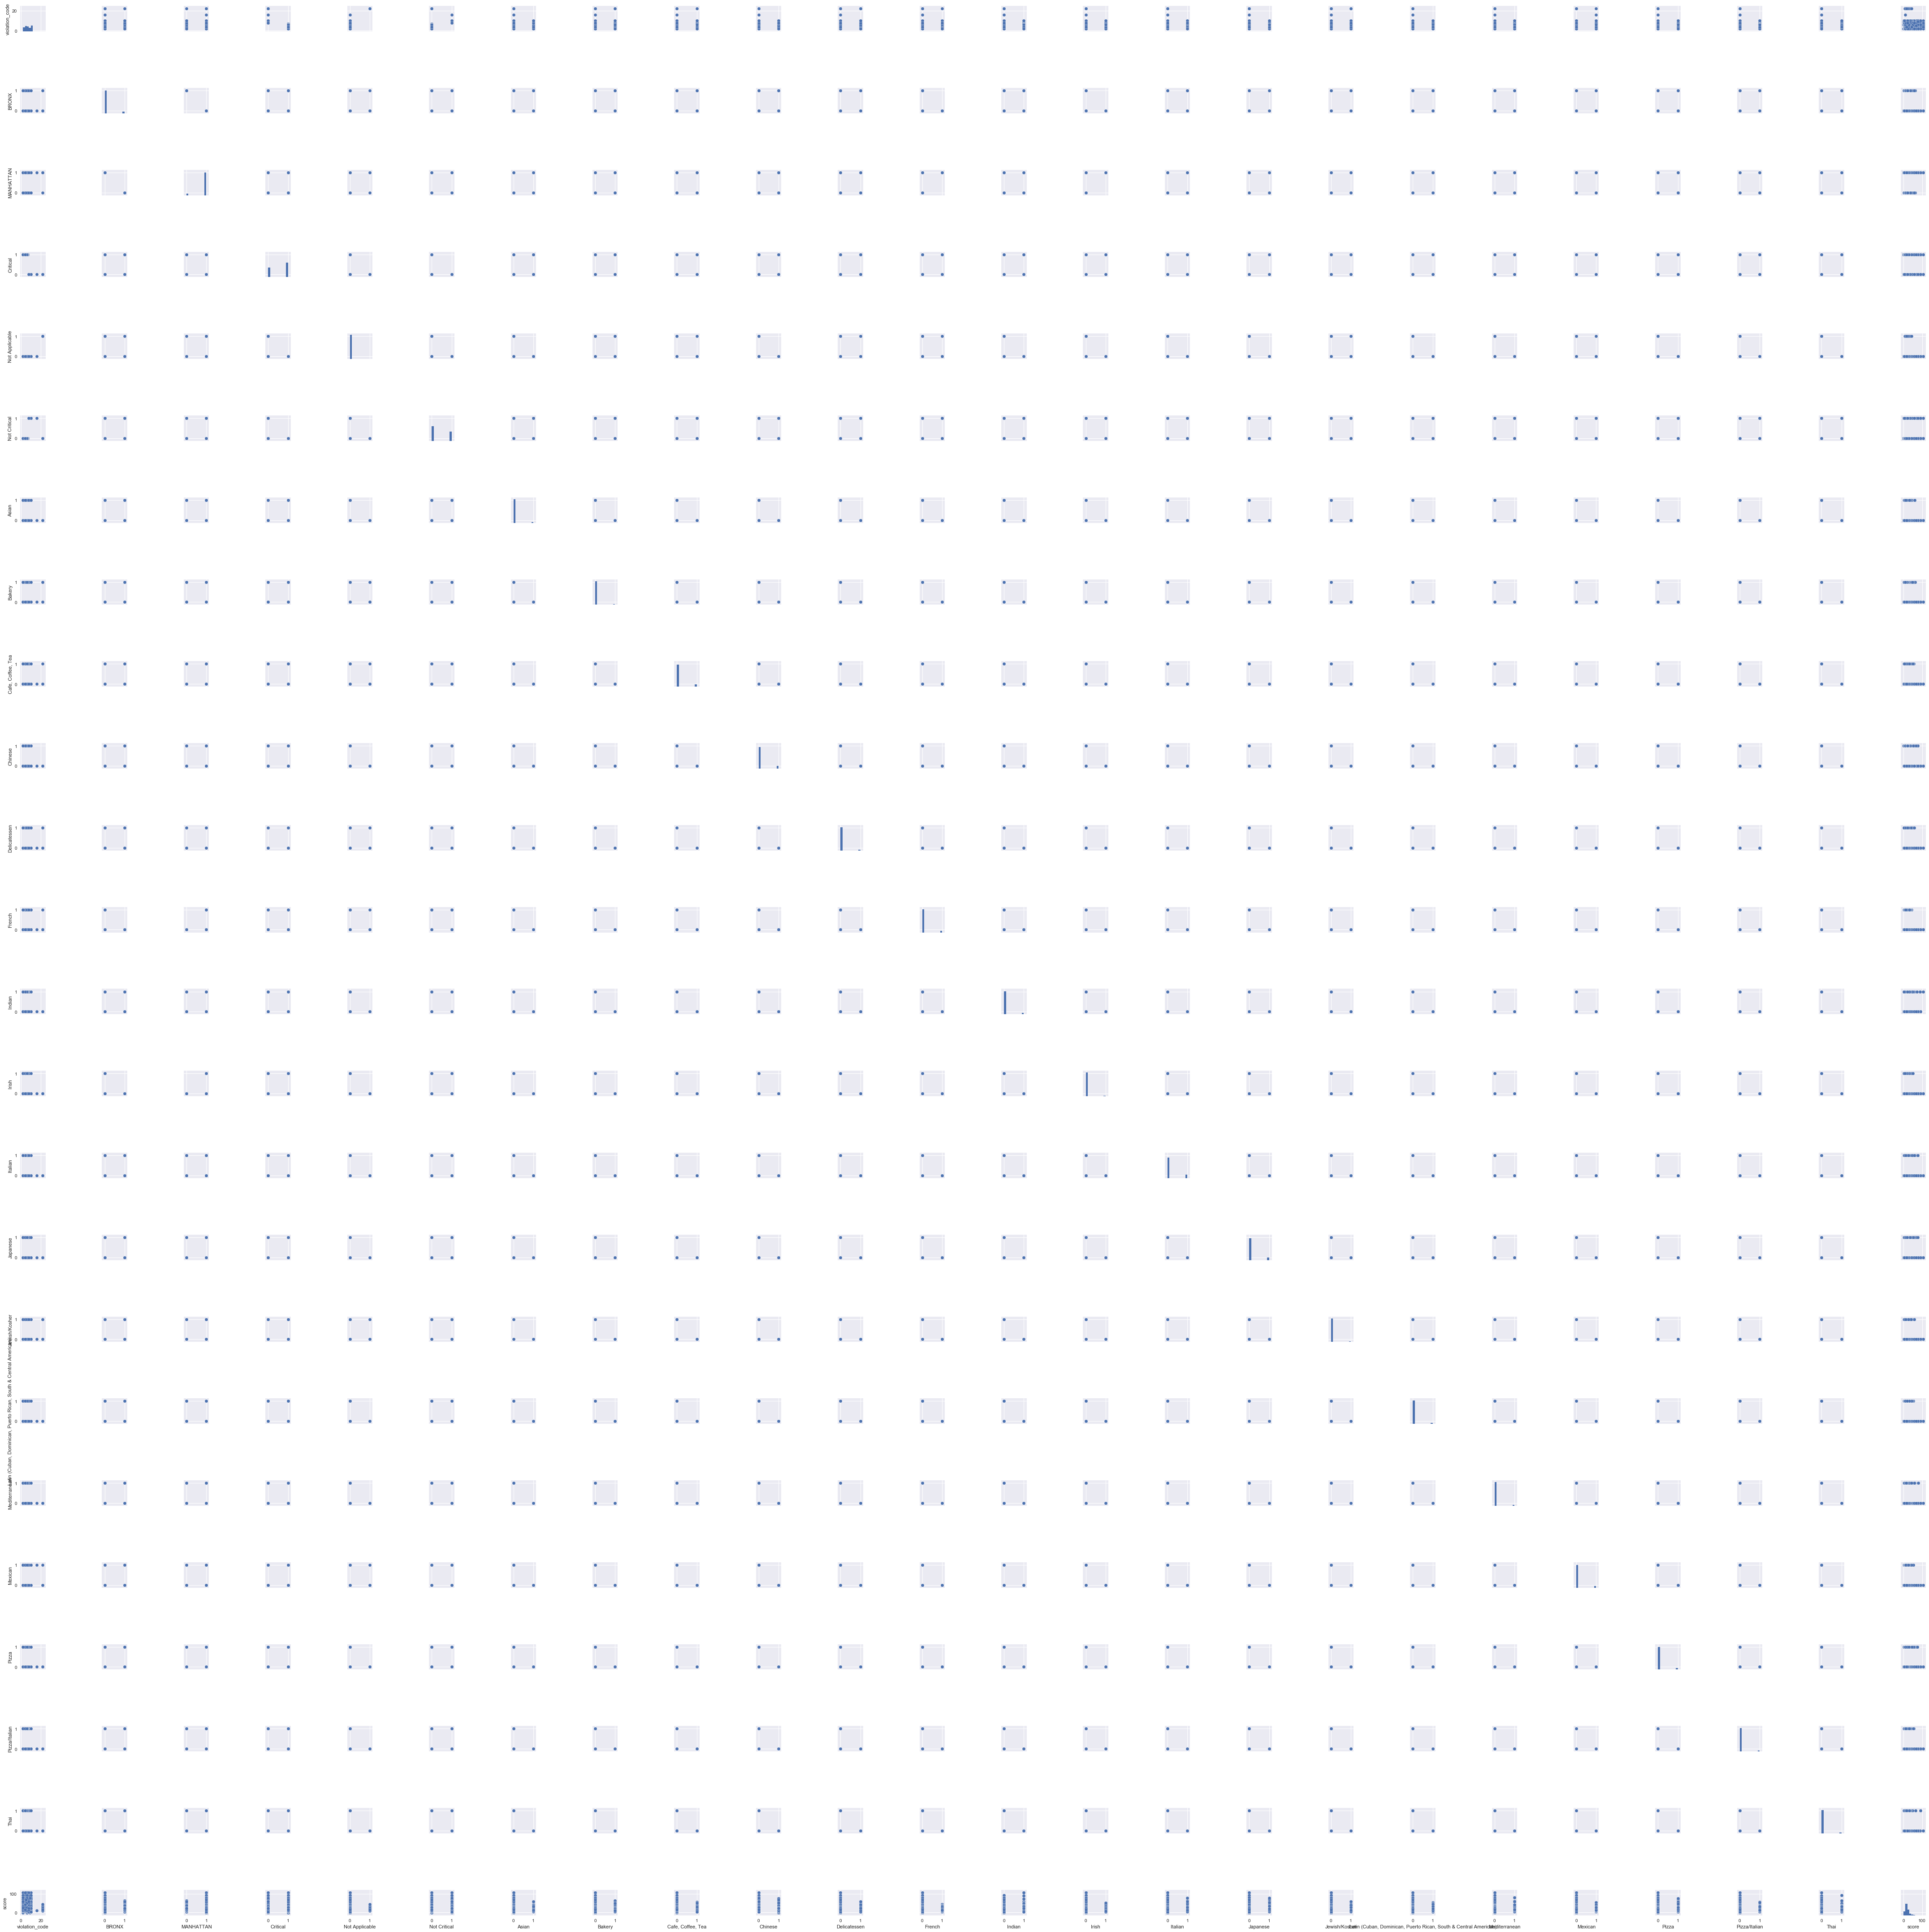

In [102]:
sns.pairplot(restdatafilter)


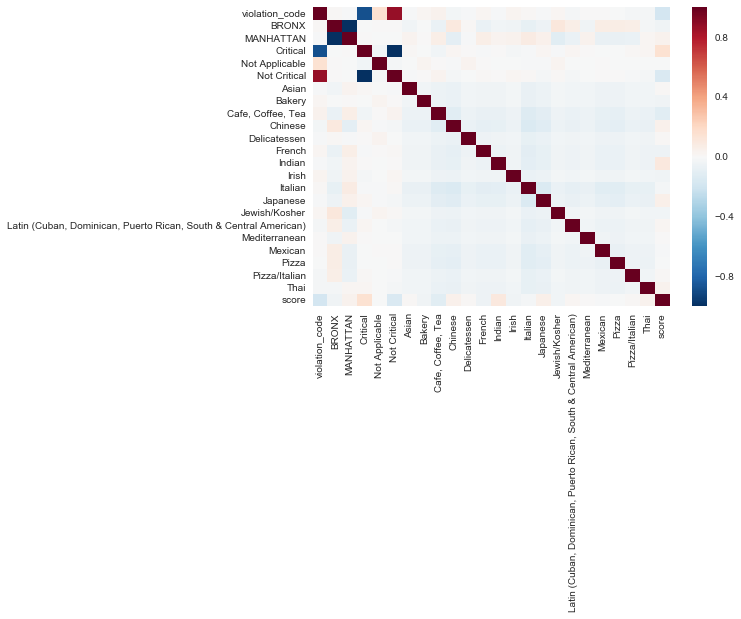

In [106]:
restcorr = restdatafilter.corr()
sns.heatmap(restcorr)


In [111]:
rest_features = restdatafilter.columns.tolist()[0:-1]

rest_features_cols = restdatafilter[rest_features]



,violation_code,BRONX,MANHATTAN,Critical,Not Applicable,Not Critical,Asian,Bakery,"Cafe, Coffee, Tea",Chinese,...,Irish,Italian,Japanese,Jewish/Kosher,"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",Mediterranean,Mexican,Pizza,Pizza/Italian,Thai
1,9,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,9,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,8,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,10,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,6,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10,10,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11,8,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,10,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
15,2,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [112]:
scaler = StandardScaler() #create a scaler object
scaler.fit(rest_features_cols) #fit the scaler
X_scaled = scaler.transform(rest_features_cols) #transform the data with it

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

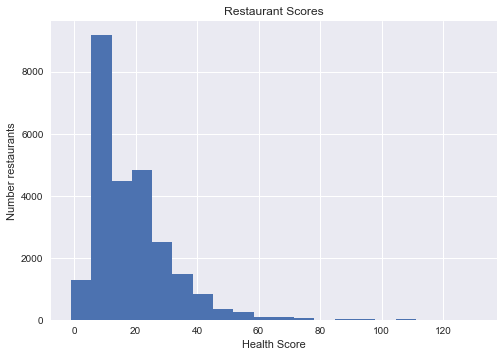

In [46]:

restdatacleaned.score.hist(bins=20)
sns.plt.title("Restaurant Scores")
sns.plt.ylabel("Number restaurants")
sns.plt.xlabel("Health Score")



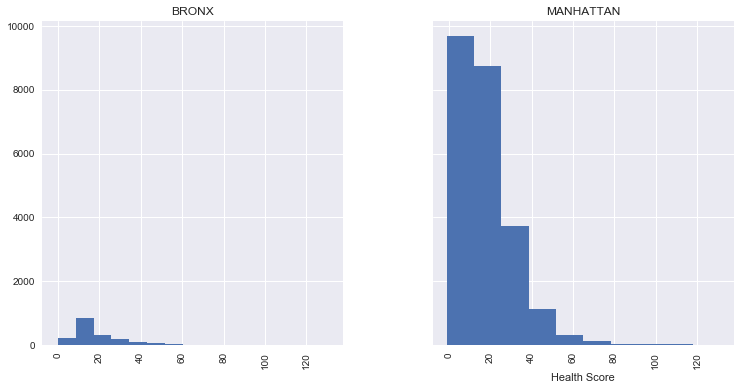

In [53]:
restdatacleaned.hist(by=restdatacleaned["boro"],bins=10,layout= (1,2),figsize=(12,6),sharex=True,sharey=True)
sns.plt.ylabel("Number restaurants")
sns.plt.xlabel("Health Score")

In [213]:
restdatacuisine = restdatacleaned.merge(cusineDF,left_index=True,right_index=True

In [ ]:
#Convert critical to flag
#Convert boros to columns
#Convert cuisines to columns
#Use decsion trees or random forrest